# Image classification using CNN

**Esther SunYoung CHOI**

Image classification is a fundamental task in Computer Vision that consists of assigning a label to an image, the label being the name of the object represented in the image.

The goal of this project is to implement a Convolutional Neural Network to perform image classification using PyTorch.


# Table of Contents
1. Intro to CNN
2. Exploring the data
3. Building a model
4. Training the model
5. Visualizing results
6. Conclusion

## Intro to CNN

Convolutional Neural Networks have become the state-of-the-art architecture in almost all Machine Learning tasks applied to images. They differ from traditional neural networks by the types of layers they use : convolutional layers and pooling layers.

### Convolutional layers

Convolutional layers perform a convolution operation between the input data and a feature detector, called kernel or filter. The filter is a small matrix that we pass over each pixel of the input image and allows the detection of features such as straight lines, edges or circles.

### Pooling layers

Pooling layers aggregate the values of the ouput tensor of convolutional layers to reduce its dimensions and amplify the extracted feature.

Common pooling functions include max pooling and average pooling that takes respectively the maximum and average value of a small aggregate of pixels.

### Fully connected layers

Fully connected layers are nothing more than a classic neural network where all neurons are connected to all neurons of the next layer, hence the name.

CNNs thus consist of two main parts : a convolutional/pooling part that breaks down the image into features and a fully connected neural network to take the final decision.

## Importing all useful modules

In [ ]:
import argparse
import os
import time
import random

from google.colab import output

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

## Exploring the data

We will be using the [CIFAR-10 database](https://www.cs.toronto.edu/~kriz/cifar.html) that contains 10 classes of 32x32 RGB images, 50k in train and 10k in test.

In [ ]:
def get_dataset(batch_size, cuda=False):
    """
    Loads the CIFAR-10 dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    trainset = datasets.CIFAR10(root='./data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    testset = datasets.CIFAR10(root='./data', train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(trainset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(testset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

In [ ]:
PRINT_INTERVAL = 100
BATCH_SIZE = 128
CUDA = True
train, test = get_dataset(batch_size=BATCH_SIZE,cuda=CUDA)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's display a few images.

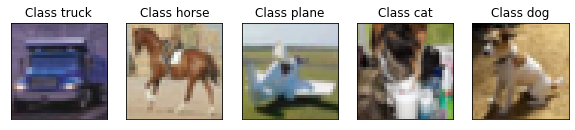

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_features, train_labels = next(iter(train))    

plt.figure(figsize=(10, 4))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    num = random.randint(0, train_features.shape[0])
    img = train_features[num].numpy().transpose((1,2,0))
    plt.imshow(img)
    plt.title("Class {}".format(classes[train_labels[num]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Building a model

In this paragraph, we will note $D$ the number of feature maps, $k$ the width of the filter, $p$ the padding and $s$ the stride.

The model we are going to build will be composed of the following layers :
- `conv1` : convolution layer with $D=32, k=5, p=2, s=1$ and ReLU activation
- `pool1` : max-pooling with window of size 2x2, $p=0,s=2$
- `conv2` : convolution layer with $D=32, k=5, p=2, s=1$ and ReLU activation
- `pool2` : max-pooling with window of size 2x2, $p=0,s=2$
- `conv3` : convolution layer with $D=32, k=5, p=2, s=1$ and ReLU activation
- `pool3` : max-pooling with window of size 2x2, $p=0,s=2$
- `fc4` : fully-connected layer with 1000 output neurons, with ReLU activation
- `fc5` : fully-connected layer with 10 output neurons, with softmax activation

The values of padding and stride are chosen so that the output of convolution layers have the same spatial dimensions (width and height) as the input, and so that pooling layers divide spatial dimensions by 2.

The table below shows the dimensions of outputs and the number of parameters to train.

| Layer | Output size | Number of weights |
| ----------- | ----------- |---|
| `conv1`      | 32 x 32 x 32       | (5 x 5 x 3 + 1) x 32 = 2,432|
| `pool1`   | 16 x 16 x 32      |0|
| `conv2`      | 16 x 16 x 64        | (5 x 5 x 32 + 1) x 64 = 51 264|
| `pool2`   | 8 x 8 x 64        |0|
| `conv3`      | 8 x 8 x 64       | (5 x 5 x 64 + 1) x 64 = 102 464|
| `pool3`   | 4 x 4 x 64         |0|
| `fc4`      | 1000 x 1    | 1000 x (4 x 4 x 64) + 1000 = 1 025 000|
| `fc5`   | 10 x 1      |10 x 1000 + 10 = 10010 |

2432 + 51 264 + 102 464 + 1 025 000 + 10010 = 1,191,170. \\
There are 1,191,170 parameters in total. Considering that there are only 50,000 examples in the training set, there is a risk of overfitting.

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

In [ ]:
model = ConvNet()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          51,264
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]         102,464
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                 [-1, 1000]       1,025,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                   [-1, 10]          10,010
Total params: 1,191,170
Trainable params: 1,191,170
Non-trainable params: 0
---------------------------

## Training the model

Now that we have designed a model, we can train it.

To do so, we will use the cross-entropy as loss function, with the SGD (Stochastic Gradient Descent) optimizer.

The following cell contains an accuracy function and classes to compute and plot metrics.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, keep_all=False):
        self.reset()
        self.data = None
        if keep_all:
            self.data = []

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.data is not None:
            self.data.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class TrainLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.fig = plt.figure()

    def update(self, loss_train):
        self.loss_train.append(loss_train)

    def plot(self):
        plt.figure(self.fig.number)
        plt.clf()
        plt.plot(np.array(self.loss_train))
        plt.title("Train loss / batch")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)

class AccLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        self.fig = plt.figure()

    def update(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        plt.figure(self.fig.number)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.array(self.acc_train), label="acc. train")
        plt.plot(np.array(self.acc_test), label="acc. test")
        plt.title("Accuracy / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(self.loss_train), label="loss train")
        plt.plot(np.array(self.loss_test), label="loss test")
        plt.title("Loss / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)

The following cell contains the code to perform a training epoch.

In [ ]:
def epoch(data, model, criterion,optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)

        if True: 
          if i % PRINT_INTERVAL == 0:
              print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                    'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                    'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                    "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                    top1=avg_top1_acc, top5=avg_top5_acc))
            #   if optimizer:
            #       loss_plot.plot()

    # Print summary
    if True: 
      print('\n===============> Total time {batch_time:d}s\t'
            'Avg loss {loss.avg:.4f}\t'
            'Avg Prec@1 {top1.avg:5.2f} %\t'
            'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
            batch_time=int(avg_batch_time.sum), loss=avg_loss,
            top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


In [ ]:
def main(model,batch_size=128, lr=0.1, epochs=100, cuda=False):
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.9)
    optimizer = torch.optim.SGD(model.parameters(), lr)
    # optimizer = torch.optim.Adam(model.parameters(), lr)
    # lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        output.clear()

        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        # lr_sched.step()

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.210s (0.210s)	Loss 0.0337 (0.0337)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/391]	Time 0.012s (0.022s)	Loss 0.0428 (0.0393)	Prec@1  97.7 ( 98.9)	Prec@5 100.0 (100.0)

===============> Total time 8s	Avg loss 0.0442	Avg Prec@1 98.76 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 2.3345 (2.3345)	Prec@1  64.8 ( 64.8)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 2.0948	Avg Prec@1 66.34 %	Avg Prec@5 96.83 %



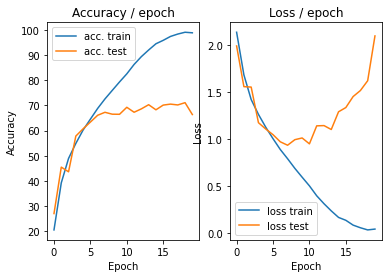

In [ ]:
model = ConvNet()
main(model,batch_size=128, lr=0.1, epochs=20, cuda=True)

We can see the test loss increasing after 10 epochs with a low accuracy (less than 70%). There is clearly an overfitting issue, as we had expected.

There exists several ways to handle overfittig, and adding Dropout layers to our model is one of them.

Dropout layers randomly remove certain features by setting them to 0 at each epoch. The model tries different combinations of neurons during and training and thus encourage the model to use all neurons individually (as their neighbors may be desactivated at any time).

Below, we define another architecture addind Dropout layers.

In [16]:
class ConvNetDropout(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNetDropout, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 10)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.2073 (0.2073)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/391]	Time 0.008s (0.020s)	Loss 0.2609 (0.2393)	Prec@1  88.3 ( 91.6)	Prec@5 100.0 ( 99.9)

===============> Total time 7s	Avg loss 0.2573	Avg Prec@1 90.93 %	Avg Prec@5 99.90 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.1746 (1.1746)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0211	Avg Prec@1 73.19 %	Avg Prec@5 97.63 %



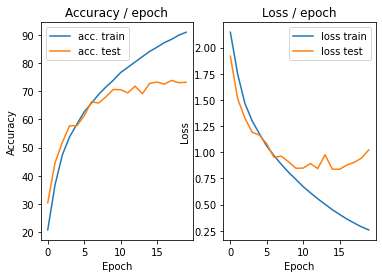

In [17]:
model2 = ConvNetDropout()
main(model2, batch_size=128, lr=0.1, epochs=20, cuda=True)

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.4043 (0.4043)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/391]	Time 0.030s (0.019s)	Loss 0.1925 (0.2153)	Prec@1  93.8 ( 92.4)	Prec@5 100.0 ( 99.9)

===============> Total time 7s	Avg loss 0.2339	Avg Prec@1 91.71 %	Avg Prec@5 99.94 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.0307 (1.0307)	Prec@1  75.8 ( 75.8)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.1079	Avg Prec@1 73.09 %	Avg Prec@5 97.67 %



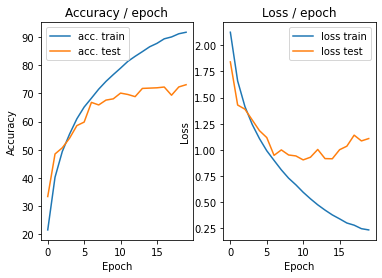

In [20]:
model2bis = ConvNetDropout()
main(model2bis, batch_size=128, lr=0.15, epochs=20, cuda=True)

In [23]:
class ConvNetReducedDropout(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNetReducedDropout, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(16, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 0.7802 (0.7802)	Prec@1  68.8 ( 68.8)	Prec@5  99.2 ( 99.2)
[TRAIN Batch 200/391]	Time 0.031s (0.023s)	Loss 0.4729 (0.6864)	Prec@1  84.4 ( 76.0)	Prec@5 100.0 ( 98.7)

===============> Total time 8s	Avg loss 0.6940	Avg Prec@1 75.67 %	Avg Prec@5 98.65 %

[EVAL Batch 000/079]	Time 0.136s (0.136s)	Loss 0.9675 (0.9675)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9655	Avg Prec@1 67.99 %	Avg Prec@5 96.78 %



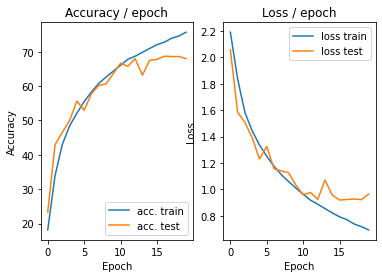

In [24]:
model3 = ConvNetReducedDropout()
main(model3, batch_size=128, lr=0.1, epochs=20, cuda=True)

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.155s (0.155s)	Loss 0.5758 (0.5758)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/391]	Time 0.009s (0.019s)	Loss 0.7079 (0.6717)	Prec@1  75.8 ( 76.0)	Prec@5  98.4 ( 98.7)

===============> Total time 7s	Avg loss 0.6981	Avg Prec@1 75.29 %	Avg Prec@5 98.58 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.9247 (0.9247)	Prec@1  74.2 ( 74.2)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0197	Avg Prec@1 66.86 %	Avg Prec@5 96.60 %



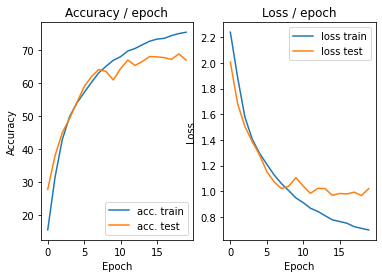

In [29]:
model3bis = ConvNetReducedDropout()
main(model3bis, batch_size=128, lr=0.2, epochs=20, cuda=True)

=== EPOCH 20 =====

[TRAIN Batch 000/196]	Time 0.207s (0.207s)	Loss 0.8990 (0.8990)	Prec@1  67.6 ( 67.6)	Prec@5  97.3 ( 97.3)

===============> Total time 6s	Avg loss 0.8206	Avg Prec@1 70.99 %	Avg Prec@5 98.07 %

[EVAL Batch 000/040]	Time 0.182s (0.182s)	Loss 1.0753 (1.0753)	Prec@1  62.5 ( 62.5)	Prec@5  96.5 ( 96.5)

===============> Total time 1s	Avg loss 1.1210	Avg Prec@1 62.50 %	Avg Prec@5 96.00 %



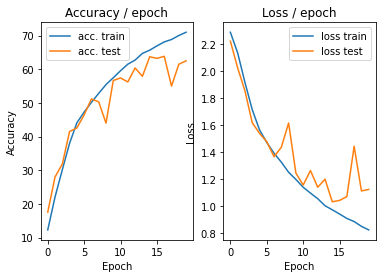

In [34]:
model3ter = ConvNetReducedDropout()
main(model3ter, batch_size=256, lr=0.2, epochs=20, cuda=True)

In [ ]:
model3quater = ConvNetReducedDropout()
main(model3quater, batch_size=350, lr=0.22, epochs=40, cuda=True)

=== EPOCH 24 =====

[TRAIN Batch 000/143]	Time 0.234s (0.234s)	Loss 0.7615 (0.7615)	Prec@1  71.7 ( 71.7)	Prec@5  98.9 ( 98.9)


## Visualizing results

We can now use our final model to predict new data.

## Conclusion

CNNs are very performant for image based machine learning tasks when used properly.